## Imports

In [1]:
from class_definitions import Program, Merit, Target, Observation, Plan, Night
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import astroplan
from astropy.time import Time, TimeDelta
from astropy.coordinates import SkyCoord, AltAz
import merits
import astropy.units as u
from tqdm.notebook import tqdm
import scheduler
from datetime import date, timedelta, datetime
import pickle
from helper_functions import load_program, build_observations

## Setup

In [2]:
# Define global observer location
lasilla = astroplan.Observer.at_site("lasilla")

In [3]:
# Define the programs
# Eventually this would be imported from the gitlab with the files.
prog600 = Program(600, 2, instrument="CORALIE")
prog703 = Program(703, 13, instrument="CORALIE")
prog708 = Program(708, 7, instrument="CORALIE")
prog714 = Program(714, 2, instrument="CORALIE")

In [4]:
start_datetime = Time("2023-10-20 03:00:00")

In [5]:
# Time(datetime.combine(date(2023, 10, 20), datetime.min.time()))
start_datetime.datetime.date()

night = Night(start_datetime.datetime.date() - timedelta(days=1), observations_within='nautical')

### Define the merits

In [6]:
# Define merits
cadence_merit = Merit("Cadence", merits.cadence, 
                      merit_type="efficiency", 
                      parameters={"delay": TimeDelta(4*u.day), "alpha":0.05})
airmass_merit = Merit("Airmass", merits.airmass, merit_type="veto", parameters={'max':1.8})
altitude_merit = Merit("Altitude", merits.altitude, merit_type="veto")
at_night_merit = Merit("AtNight", merits.at_night, merit_type="veto")
culmination_merit = Merit("Culmination", merits.culmination, merit_type="efficiency")
egress_merit = Merit("Egress", merits.egress, merit_type="efficiency")

In [7]:
merits_list = [airmass_merit, altitude_merit, 
               at_night_merit, culmination_merit, egress_merit]

### Load the targets

In [8]:
pct_keep = 0.75

Targets from 600

In [9]:
targets_600 = load_program("programs/Prog600COR_2023-10-19_obsinfo.csv", 
                           prog600, merits_list, pct_keep=pct_keep)
len(targets_600)

4

Targets from 708

In [10]:
targets_708 = load_program("programs/Prog708COR_2023-10-19_obsinfo.csv", 
                           prog708, merits_list, pct_keep=pct_keep)
len(targets_708)

15

Targets from 714

In [11]:
targets_714 = load_program("programs/Prog714COR_2023-10-19_obsinfo.csv", 
                           prog714, merits_list, pct_keep=pct_keep)
len(targets_714)

64

### Build the observations

In [12]:
# Merge the two programs
targets_all = targets_600 + targets_708 + targets_714

In [13]:
obs_600 = build_observations(targets_600, start_datetime, 
                             night, TimeDelta(20*u.min), "programs/obs_600.pkl")

In [14]:
obs_708 = build_observations(targets_708, start_datetime, 
                             night, TimeDelta(15*u.min), "programs/obs_708.pkl")

In [15]:
obs_714 = build_observations(targets_714, start_datetime, 
                             night, TimeDelta(15*u.min), "programs/obs_714.pkl")

In [16]:
test_observations = obs_600 + obs_708 + obs_714

## Test the merits

In [17]:
test_obs = test_observations[0]
print(test_obs)
print(test_obs.target)

Observation(Target: HD1581,
            Start time: 2460237.625,
            Exposure time: 0.013888888888888888,
            Score: 0.0)
Target(Name: HD1581,
       Program: 600,
       Coordinates: <SkyCoord (ICRS): (ra, dec) in deg
    (5.01791667, -64.87472222)>,
       Last observation: 2460178.84805948,
       Priority: 1.0,
       Veto Merits: [Merit(Airmass, veto, {'max': 1.8}), Merit(Altitude, veto, {}), Merit(AtNight, veto, {})],
       Efficiency Merits: [Merit(Culmination, efficiency, {}), Merit(Egress, efficiency, {})])


In [18]:
print(f"Cadence merit = {cadence_merit.evaluate(test_obs, verbose=True)}")

observation.start_time = 2460237.625
observation.target.last_obs = 2460178.84805948
delay.value = 4.0
Cadence merit = 2.840447404235384


In [19]:
print(f"Airmass merit = {airmass_merit.evaluate(test_obs)}")

Airmass merit = True


In [20]:
print(f"Altitude merit = {altitude_merit.evaluate(test_obs)}")

Altitude merit = True


In [21]:
print(f"Culmination merit = {culmination_merit.evaluate(test_obs, verbose=True)}")

Current altitude: 54.47529253685186
Max altitude: 54.51171089210749
Min altitude: 26.500720105594215
Altitude proportion: 0.9986998547986685
Culmination merit = 0.9986998547986685


In [22]:
print(f"Egress merit = {egress_merit.evaluate(test_observations[16], verbose=True)}")

Current time: 2460237.625
First time: 2460237.5760950577
Last time: 2460238.043685746
Observable range proportion: 0.10458921354991348
Egress merit = 0.10458921354991348


In [23]:
test_obs.feasible()
test_obs.evaluate_score(verbose=True)

Current altitude: 54.47529253685186
Max altitude: 54.51171089210749
Min altitude: 26.500720105594215
Altitude proportion: 0.9986998547986685
Current time: 2460237.625
First time: 2460237.3400395173
Last time: 2460237.925030735
Observable range proportion: 0.4871192492576575
Fairness: 1.0
Sensibility: 1.0
Efficiency: 0.742909552028163
Rank score: 0.742909552028163


0.742909552028163

# Test the Schedulers

In [24]:
# Create the plan
plan_start = night.nautical_evening

## Simple greedy search

Greedy search is the equivalent of using `generateQ` with `K=1`

In [25]:
gQ_scheduler = scheduler.generateQ(plan_start)

# Create the plan
greedy_plan = gQ_scheduler.generateQ(test_observations, 
                                    max_plan_length = None, 
                                    K=1)

In [26]:
greedy_plan.print_stats()

Length = 34
Score = 0.745264
Evaluation = 0.699518
Overhead time = 0.32453 h
Overhead ratio = 0.03709
Observation time = 8.75000 h
Observation ratio = 0.93862


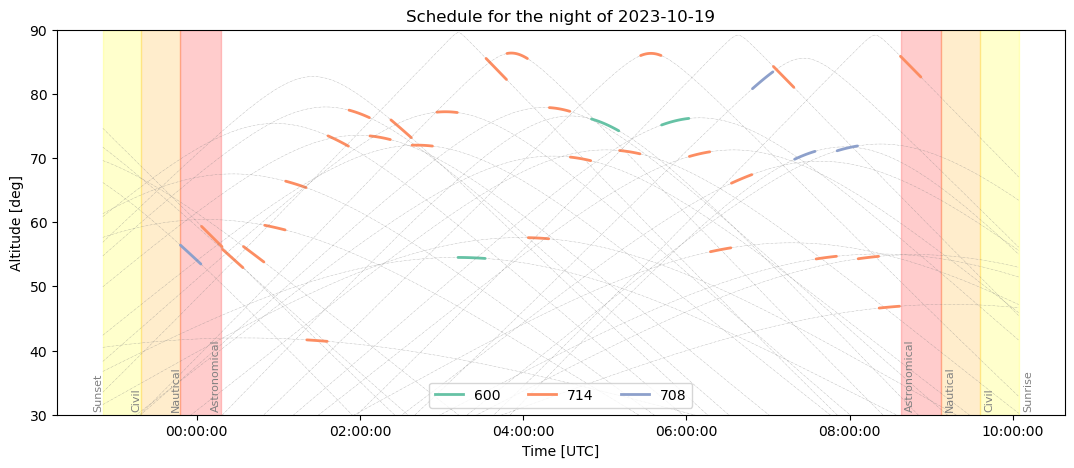

In [27]:
greedy_plan.plot()

AttributeError: 'Axes' object has no attribute 'xlabel'

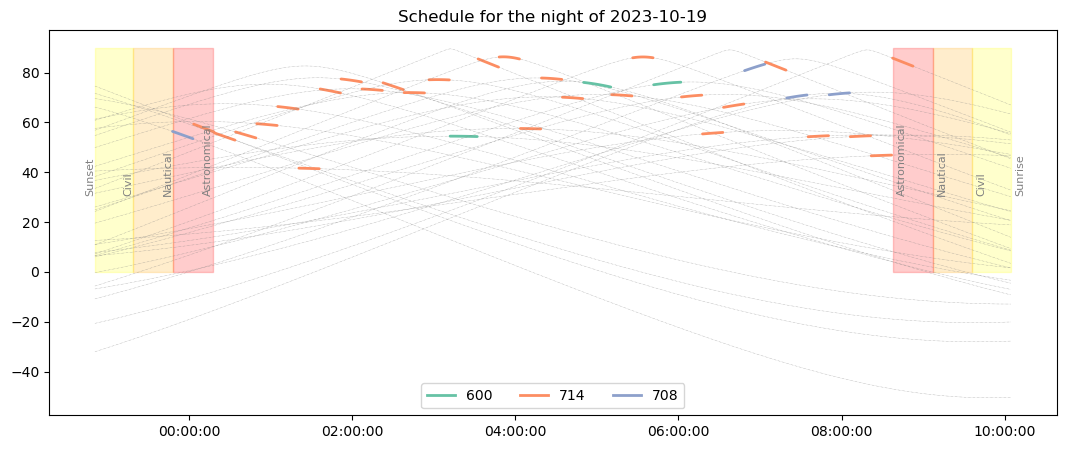

In [28]:
greedy_plan.plot2()

## Greedy Look-Ahead with Top-K Selection: `generateQ`

This is similar to the simple greedy search but with a lookahead of the top K observations at each step. This approach explores different permutations of the top K observations and thus chooses the best one by looking forward.

In [28]:
# gQ_scheduler = scheduler.generateQ(plan_start)

# Create the plan
gQ_plan = gQ_scheduler.generateQ(test_observations, 
                                 max_plan_length = None, 
                                 K=4)

In [29]:
gQ_plan.print_stats()

Length = 34
Score = 0.756151
Evaluation = 0.709737
Overhead time = 0.51282 h
Overhead ratio = 0.05861
Observation time = 8.75000 h
Observation ratio = 0.93862


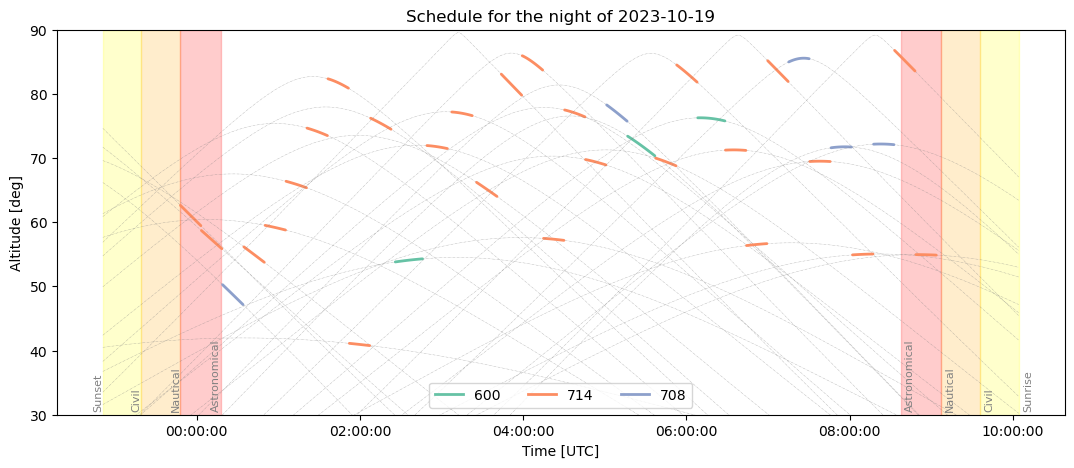

In [30]:
gQ_plan.plot()

## Recursive Dynamic Programming

In [31]:
# dpplanner = scheduler.DPPlanner()

# dpplan = dpplanner.dp_recursion(test_observations_noegress, 
#                                 Plan(), 
#                                 max_plan_length=10,
#                                 K = 4)

In [32]:
# print(f"Total recursion calls: {dpplanner.total_counter}")
# print(f"Saved recursion calls: {dpplanner.saved_state_counter}")

# print(dpplan[1])

In [33]:
# dpplan[1].plot()

## Beam Search

In [34]:
beamsearch = scheduler.BeamSearchPlanner(plan_start)

bs_plan = beamsearch.dp_beam_search(test_observations, 
                                    max_plan_length=None, 
                                    K=4)

In [35]:
bs_plan.print_stats()

Length = 33
Score = 0.719799
Evaluation = 0.662748
Overhead time = 0.48519 h
Overhead ratio = 0.05653
Observation time = 8.58333 h
Observation ratio = 0.92074


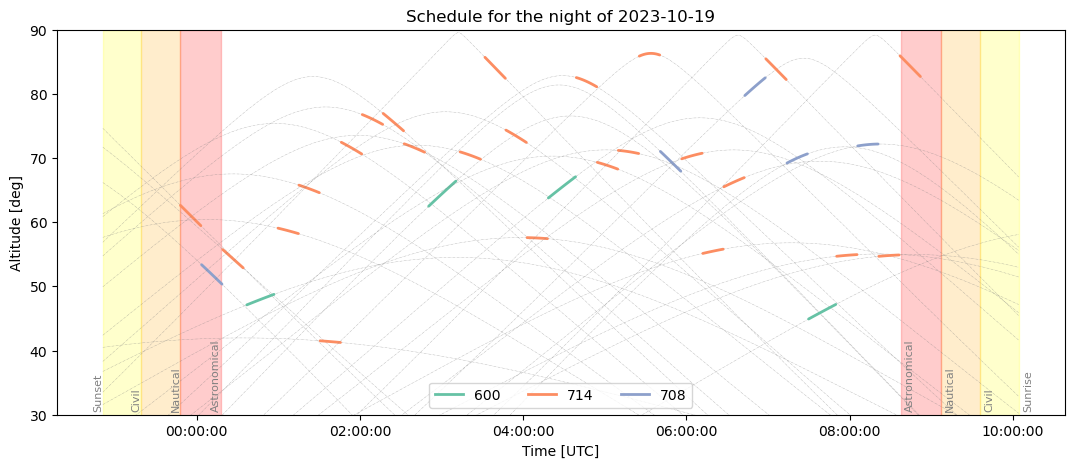

In [36]:
bs_plan.plot()

/tmp/ipykernel_107756/2632299776.py:6: RuntimeWarning: invalid value encountered in arccos
  z_rad = np.arccos(1 / airmass)


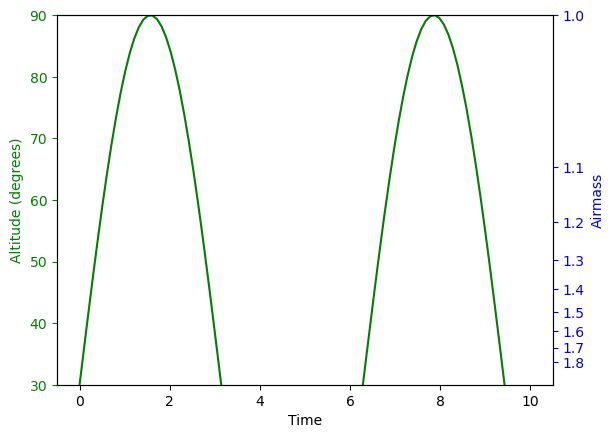

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# Compute altitude in degrees from airmass
def airmass_to_altitude(airmass):
    z_rad = np.arccos(1 / airmass)
    return 90 - np.degrees(z_rad)

# Sample data
time = np.linspace(0, 10, 100)
altitude_degrees = 30 + 60 * np.sin(time)

fig, ax1 = plt.subplots()

# Plot data on the primary y-axis (Altitude in degrees)
ax1.plot(time, altitude_degrees, 'g-')
ax1.set_xlabel('Time')
ax1.set_ylabel('Altitude (degrees)', color='g')
ax1.set_yticks(np.arange(30, 91, 10))
ax1.tick_params('y', colors='g')
ax1.set_ylim(30, 90)

# Set up airmass values and compute the corresponding altitudes for those airmass values
desired_airmasses = np.arange(1.8, 0.9, -0.1)
corresponding_altitudes = airmass_to_altitude(desired_airmasses)
corresponding_altitudes[-1] = 90.0

# Create the secondary y-axis for Airmass
ax2 = ax1.twinx()
ax2.set_ylim(ax1.get_ylim())
ax2.set_yticks(corresponding_altitudes)  # Set y-ticks at computed altitudes for desired airmasses
ax2.set_yticklabels(np.round(desired_airmasses, 2))  # Display the desired airmass values
ax2.set_ylabel('Airmass', color='b')
ax2.tick_params('y', colors='b')

plt.show()


In [44]:
desired_airmasses

array([1.8, 1.7, 1.6, 1.5, 1.4, 1.3, 1.2, 1.1, 1. ])

In [45]:
corresponding_altitudes

array([33.7489886 , 36.03187907, 38.68218745, 41.8103149 , 45.5846914 ,
       50.28486277, 56.44269024, 65.38002267,         nan])

In [51]:
ax1.xaxis